In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold

In [2]:
db=pd.read_csv("health care diabetes.csv")

In [3]:
db.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
#Missing Value treatment
#since the value distribution is Skewed, we will replace zero values with median
db1=db.copy()
# def function to treat Missing value

def glu_missing(a):
    outcome=a[0]
    glucose=a[1]
    if glucose==0 and outcome==0:
        return db1[db1['Outcome']==0]['Glucose'].median()
    elif glucose==0 and outcome==1:
        return db1[db1['Outcome']==1]['Glucose'].median()
    else:
        return glucose

def bp_missing(a):
    outcome=a[0]
    glucose=a[1]
    if glucose==0 and outcome==0:
        return db1[db1['Outcome']==0]['BloodPressure'].median()
    elif glucose==0 and outcome==1:
        return db1[db1['Outcome']==1]['BloodPressure'].median()
    else:
        return glucose
    
def st_missing(a):
    outcome=a[0]
    glucose=a[1]
    if glucose==0 and outcome==0:
        return db1[(db1['Outcome']==0) & (db1['SkinThickness']!=0)]['SkinThickness'].median()
    elif glucose==0 and outcome==1:
        return db1[(db1['Outcome']==1) & (db1['SkinThickness']!=0)]['SkinThickness'].median()
    else:
        return glucose
    
def insulin_missing(a):
    outcome=a[0]
    glucose=a[1]
    if glucose==0 and outcome==0:
        return db1[(db1['Outcome']==0) & (db1['Insulin']!=0)]['Insulin'].median()
    elif glucose==0 and outcome==1:
        return db1[(db1['Outcome']==1) & (db1['Insulin']!=0)]['Insulin'].median()
    else:
        return glucose
    
def BMI_missing(a):
    outcome=a[0]
    glucose=a[1]
    if glucose==0 and outcome==0:
        return db1[db1['Outcome']==0]['BMI'].median()
    elif glucose==0 and outcome==1:
        return db1[db1['Outcome']==1]['BMI'].median()
    else:
        return glucose
    
db1['Glucose']=db1[['Outcome','Glucose']].apply(glu_missing,axis=1)
db1['BloodPressure']=db1[['Outcome','BloodPressure']].apply(bp_missing,axis=1)
db1['SkinThickness']=db1[['Outcome','SkinThickness']].apply(st_missing,axis=1)
db1['Insulin']=db1[['Outcome','Insulin']].apply(insulin_missing,axis=1)
db1['BMI']=db1[['Outcome','BMI']].apply(BMI_missing,axis=1)


In [5]:
db1.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.60,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.60,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.30,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.10,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.10,2.288,33,1
5,5,116.0,74.0,27.0,102.5,25.60,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.00,0.248,26,1
7,10,115.0,70.0,27.0,102.5,35.30,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.50,0.158,53,1
9,8,125.0,96.0,32.0,169.5,34.25,0.232,54,1


Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87        95
           1       0.77      0.86      0.82        59

    accuracy                           0.85       154
   macro avg       0.84      0.85      0.85       154
weighted avg       0.86      0.85      0.85       154

Classification report for Random Forest with RGCV +stratified:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87        95
           1       0.75      0.92      0.82        59

    accuracy                           0.85       154
   macro avg       0.84      0.86      0.85       154
weighted avg       0.87      0.85      0.85       154

AUC with Random forest with RandomsearchCV + strafied: 0.9389830508474577


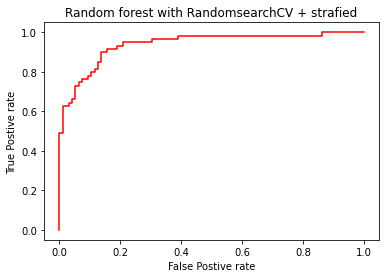

In [6]:
# Modelling Work
x=db1.iloc[:,:8]
y=db1['Outcome']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)

smote=SMOTE(random_state=10)
x_train_smote,y_train_smote=smote.fit_resample(x_train,y_train)

#RandomForest

clf=RandomForestClassifier(random_state=10)
model_rf=clf.fit(x_train_smote,y_train_smote)
y_pred_rf=model_rf.predict(x_test)
RF_acuracy=accuracy_score(y_test,y_pred_rf)
pd.crosstab(y_test,y_pred_rf)
print("Classification report for Random Forest:\n",classification_report(y_test,y_pred_rf))
#Improving Random Forest Model

skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state':[10]
}
ran_skf_rf=RandomizedSearchCV(clf,param_distributions=param_grid,n_iter=15,scoring='recall',n_jobs=-1,cv=skf,random_state=10)
model_rf_skf=ran_skf_rf.fit(x_train_smote,y_train_smote)
y_pred_rf_skf=model_rf_skf.predict(x_test)
pd.crosstab(y_test,y_pred_rf_skf)
print("Classification report for Random Forest with RGCV +stratified:\n",classification_report(y_test,y_pred_rf_skf))
RF_RGCV_Str_acuracy=accuracy_score(y_test,y_pred_rf_skf)
y_pred_rf_skf_prob=model_rf_skf.predict_proba(x_test)[:,1]
RF_RGCV_Str_auc=roc_auc_score(y_test,y_pred_rf_skf_prob)
print("AUC with Random forest with RandomsearchCV + strafied:",RF_RGCV_Str_auc)
fpr,tpr,thrs=roc_curve(y_test,y_pred_rf_skf_prob)
plt.title("Random forest with RandomsearchCV + strafied")
plt.xlabel('False Postive rate')
plt.ylabel('True Postive rate')
plt.plot(fpr,tpr,color='r')
plt.show()



In [7]:
pickle.dump(model_rf_skf,open('my_model.pkl','wb'))

In [ ]:
# model=pickle.load(open('my_model.pkl','rb'))